<a href="https://colab.research.google.com/github/KaifAhmad1/Audio-Emotion-Analysis/blob/main/Audio_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Audio Data Preprocessing and Audio Sentiment and Emotion Analysis:

**Installing Necessary Dependencies:**

In [24]:
!pip install -qU \
     librosa \
     plotly

In [25]:
import os
import numpy as np
import pandas as pd
import librosa
import plotly.graph_objects as go
import plotly.io as pio
from skimage.io import imread

In [26]:
# Set seed for reproducibility
seed = 12
np.random.seed(seed)

In [27]:
trainset_data = '/content/drive/MyDrive/audio-sentiment-data/TEST'
testset_data = '/content/drive/MyDrive/audio-sentiment-data/TRAIN'
file_path = '/content/drive/MyDrive/audio-sentiment-data/speech-emotion-data.csv'
speech_data = pd.read_csv(file_path)

In [28]:
trainset_data

'/content/drive/MyDrive/audio-sentiment-data/TEST'

In [29]:
testset_data

'/content/drive/MyDrive/audio-sentiment-data/TRAIN'

**Data Exploration:**

In [30]:
print(speech_data)

    Filename     Class
0    346.wav  Negative
1    163.wav   Neutral
2    288.wav  Negative
3    279.wav  Negative
4    244.wav  Negative
..       ...       ...
245  204.wav   Neutral
246   46.wav  Positive
247  318.wav  Negative
248   49.wav  Positive
249  191.wav   Neutral

[250 rows x 2 columns]


In [31]:
speech_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Filename  250 non-null    object
 1   Class     250 non-null    object
dtypes: object(2)
memory usage: 4.0+ KB


In [32]:
speech_data.describe()

Filename     Class
count       250       250
unique      250         3
top     346.wav  Negative
freq          1        87

In [33]:
num_samples = speech_data.shape[0]
print(f"Dataset has {num_samples} samples")

print("Count of Positive and Negative samples:")
class_counts = speech_data['Class'].value_counts().reset_index()
print(class_counts)

Dataset has 250 samples
Count of Positive and Negative samples:
      index  Class
0  Negative     87
1  Positive     82
2   Neutral     81


**Audio Preprocessing:**

In [34]:
import librosa
# Set the sample rate for audio processing
sample_rate = 44100
def load_audio(file_path):
    # Load audio using librosa with specified parameters
    return librosa.load(file_path, sr=sample_rate, duration=2.5, offset=0.5)

In [35]:
import sys
def extract_mel_spectrogram_features(path, avg_feat=0):
    features = []
    min_feat = sys.maxsize
    max_feat = 0
    files = sorted(os.listdir(path))

    print("Scanning", path)

    for i, fp in enumerate(files):
        X, sr = load_audio(os.path.join(path, fp))

        mel_spec = librosa.feature.melspectrogram(y=X, sr=sample_rate)
        mel_spec_db = librosa.amplitude_to_db(mel_spec, ref=np.max)

        shapeY = mel_spec_db.shape[1]
        if shapeY < min_feat:
            min_feat = shapeY

        if shapeY > max_feat:
            max_feat = shapeY

        features.append(mel_spec_db)

    if avg_feat == 0:
        avg_feat = int((min_feat + max_feat) / 2)

    feat_mat = np.zeros((len(files), mel_spec_db.shape[0], avg_feat))

    for i, x in enumerate(features):
        x_width = min(x.shape[1], avg_feat)
        feat_mat[i, :, :x_width] = x[:, :x_width]

    return feat_mat, files

In [36]:
# Extract Mel spectrogram features from audio files
f_dim = 128
train_data, train_files = extract_mel_spectrogram_features(trainset_data, f_dim)
test_data, test_files = extract_mel_spectrogram_features(testset_data, train_data.shape[1])

Scanning /content/drive/MyDrive/audio-sentiment-data/TEST
Scanning /content/drive/MyDrive/audio-sentiment-data/TRAIN


In [37]:
# Displaying the shape of extracted features
print(train_data.shape)
print(test_data.shape)

(110, 128, 128)
(250, 128, 128)


In [38]:
import matplotlib.pyplot as plt

In [16]:
# MelSpec -> Images
def save_image(f, fp):
    f = np.flip(f, axis=0)
    plt.figure()
    plt.axis('off')
    plt.imsave(fp, f, format='png')
    plt.clf()

In [39]:
# Function to save Mel spectrogram features as images
def save_feature_to_image(path, save_dir, avg_feat=0):
    global sample_rate
    files = sorted(os.listdir(path))

    print("Scanning", path)

    for i, fp in enumerate(files):
        X, sr = load_audio(os.path.join(path, fp))

        mel_spec = librosa.feature.melspectrogram(y=X, sr=sample_rate)
        mel_spec_db = librosa.amplitude_to_db(mel_spec, ref=np.max)

        img = np.zeros((mel_spec_db.shape[0], avg_feat))
        x_width = min(mel_spec_db.shape[1], avg_feat)
        img[:, :x_width] = mel_spec_db[:, :x_width]

        fname = os.path.join(save_dir, fp.split('.')[0] + '.png')
        save_image(img, fname)

In [40]:
# Image Configuration
f_dim = 128
train_img_dir = './train_images'
test_img_dir = './test_images'

# Create image directories if they don't exist
if not os.path.exists(train_img_dir):
    os.mkdir(train_img_dir)
    save_feature_to_image(trainset_data, train_img_dir, f_dim)

if not os.path.exists(test_img_dir):
    os.mkdir(test_img_dir)
    save_feature_to_image(testset_data, test_img_dir, train_data.shape[1])

In [41]:
# Function to scan image features
def scan_img_features(path):
    features = []
    files = sorted(os.listdir(path))

    for x in files:
        fp = os.path.join(path, x)
        img = imread(fp)[:, :, :3] / 255.0
        features.append(img)

    return np.array(features), files

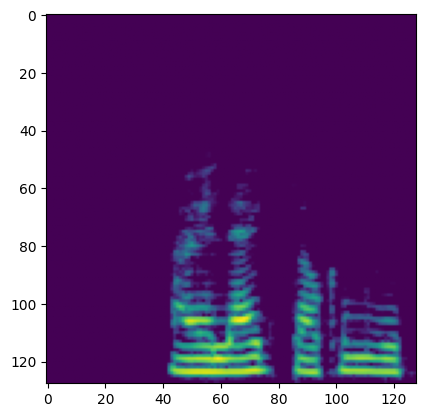

In [42]:
# Load image features
if os.path.exists(train_img_dir):
    train_data_img, train_files_img = scan_img_features(train_img_dir)

if os.path.exists(test_img_dir):
    test_data_img, test_files_img = scan_img_features(test_img_dir)

# Displaying an example image
plt.imshow(test_data_img[0])
plt.show()

In [44]:
def get_path_labels(p):
    labels = []
    for x in p:
        matching_rows = speech_data[speech_data['Filename'] == x]
        if not matching_rows.empty:
            label = matching_rows.iloc[0, 1]
            labels.append(label)
        else:
            print(f"No match found for filename: {x}")

    return labels

# Get labels for training data
train_labels = get_path_labels(train_files)

No match found for filename: 112.wav
No match found for filename: 113.wav
No match found for filename: 115.wav
No match found for filename: 119.wav
No match found for filename: 123.wav
No match found for filename: 124.wav
No match found for filename: 125.wav
No match found for filename: 128.wav
No match found for filename: 13.wav
No match found for filename: 130.wav
No match found for filename: 131.wav
No match found for filename: 132.wav
No match found for filename: 134.wav
No match found for filename: 135.wav
No match found for filename: 136.wav
No match found for filename: 138.wav
No match found for filename: 141.wav
No match found for filename: 142.wav
No match found for filename: 143.wav
No match found for filename: 146.wav
No match found for filename: 15.wav
No match found for filename: 152.wav
No match found for filename: 157.wav
No match found for filename: 158.wav
No match found for filename: 165.wav
No match found for filename: 173.wav
No match found for filename: 175.wav
No 

**Audio Data Visualization:**

In [46]:
audiofile_path = '/content/drive/MyDrive/audio-sentiment-data/TRAIN/1.wav'

In [47]:
audio_data, audio_sampling_rate = load_audio(audiofile_path)

In [48]:
import IPython
# play sample file
IPython.display.Audio(audio_data, rate=audio_sampling_rate)

In [54]:
import plotly.express as px
import librosa.display

fig = px.line(x=range(len(audio_data)), y=audio_data)
fig.update_layout(title='Waveform Plot', xaxis_title='Sample Index', yaxis_title='Amplitude')
fig.show()

In [61]:
import plotly.graph_objects as go
import librosa.display
import numpy as np

# Assuming you have 'audio_data' and 'audio_sampling_rate' available
n_fft = 2048  # window size
hop_length = 512  # window hop length for STFT

# Compute the short-time Fourier transform (STFT)
stft = librosa.stft(audio_data, n_fft=n_fft, hop_length=hop_length)

# Convert amplitude to decibel scale
stft_db = librosa.amplitude_to_db(np.abs(stft), ref=np.max)

# Get frequency and time values
freqs = np.fft.fftfreq(n_fft, 1/audio_sampling_rate)
times = np.arange(stft.shape[1]) * hop_length / audio_sampling_rate

# Plot spectrogram with amplitude
fig1 = go.Figure()

fig1.add_trace(go.Heatmap(
    x=times,
    y=freqs,
    z=np.abs(stft),
    colorscale='Viridis',
    colorbar=dict(title='Amplitude'),
))

fig1.update_layout(
    title='Spectrogram with Amplitude',
    xaxis_title='Time (s)',
    yaxis_title='Frequency (Hz)',
)

fig1.show()

# Plot spectrogram with decibel log
fig2 = go.Figure()

fig2.add_trace(go.Heatmap(
    x=times,
    y=freqs,
    z=stft_db,
    colorscale='Viridis',
    colorbar=dict(title='Decibel (dB)'),
))

fig2.update_layout(
    title='Spectrogram with Decibel Log',
    xaxis_title='Time (s)',
    yaxis_title='Frequency (Hz)',
)

fig2.show()

In [63]:
import plotly.graph_objects as go
import librosa.display
import numpy as np

# Assuming you have 'audio_data' and 'sample_rate' available
melspec = librosa.feature.melspectrogram(y=audio_data, sr=sample_rate)
melspec_db = librosa.amplitude_to_db(melspec, ref=np.max)

# Get time values
times = librosa.times_like(melspec_db)

# Plot mel spectrogram with amplitude
fig1 = go.Figure()

fig1.add_trace(go.Heatmap(
    x=times,
    y=np.arange(melspec.shape[0]),
    z=melspec,
    colorscale='Viridis',
    colorbar=dict(title='Amplitude'),
))

fig1.update_layout(
    title='Mel Spectrogram with Amplitude',
    xaxis_title='Time (s)',
    yaxis_title='Mel Frequency',
)

fig1.show()

# Plot mel spectrogram with decibel log
fig2 = go.Figure()

fig2.add_trace(go.Heatmap(
    x=times,
    y=np.arange(melspec_db.shape[0]),
    z=melspec_db,
    colorscale='Viridis',
    colorbar=dict(title='Decibel (dB)'),
))

fig2.update_layout(
    title='Mel Spectrogram with Decibel Log',
    xaxis_title='Time (s)',
    yaxis_title='Mel Frequency',
)

fig2.show()

**Audio Data Preparation:**

In [65]:
# map labels to index
label_index = {label: i for i, label in enumerate(speech_data['Class'].unique())}
index_label = {i: label for i, label in enumerate(speech_data['Class'].unique())}
print(label_index)
print(index_label)

{'Negative': 0, 'Neutral': 1, 'Positive': 2}
{0: 'Negative', 1: 'Neutral', 2: 'Positive'}


In [67]:
# update labels in df to index
train_labels_idx = [label_index[l] for l in train_labels]
train_labels_idx[::10]

[]

**Train Test Split:**

In [68]:
import pandas as pd
from sklearn.model_selection import train_test_split
# shuffle samples
df_shuffle = speech_data.sample(frac=1, random_state=seed).reset_index(drop=True)

# split into train and test
df_train, df_test = train_test_split(df_shuffle, test_size=0.2, random_state=seed, stratify=df_shuffle['Class'])

print(f"Train set has {len(df_train)} records out of {len(df_shuffle)} which is {round(len(df_train)/len(df_shuffle)*100)}%")
print(f"Test set has {len(df_test)} records out of {len(df_shuffle)} which is {round(len(df_test)/len(df_shuffle)*100)}%")

# You can access the labels as follows:
y_train = df_train['Class']
y_test = df_test['Class']

Train set has 200 records out of 250 which is 80%
Test set has 50 records out of 250 which is 20%


In [69]:
# stratified split check
print(y_train.value_counts())
print(y_test.value_counts())

Negative    69
Positive    66
Neutral     65
Name: Class, dtype: int64
Negative    18
Neutral     16
Positive    16
Name: Class, dtype: int64


In [70]:
X_train = train_data[y_train.index, :, :]
X_test = train_data[y_test.index, :, :]

# Printing the shape of X_test
print(X_test.shape)

IndexError: index 114 is out of bounds for axis 0 with size 110

In [71]:
print(train_data.shape)

(110, 128, 128)


In [72]:
print(len(y_train.index))
print(train_data.shape[0])

200
110


In [73]:
print(y_train.index.duplicated().any())

False
